### Deng AI Neg Binomial
Notebook to test negative binomial disitribution model
#### Environment and Data Prep

In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tools import eval_measures

In [ ]:
#Run the utils notebook
%run DengAI-Utils.ipynb


In [30]:
#pre-process the data
df_x_train_sj, df_y_train_sj, df_x_test_sj, df_y_test_sj, df_x_valid_sj, df_y_valid_sj, df_x_pred_sj, df_y_pred_sj=pre_process_data(
    city='sj',
    train_split=0.8,
    test_split=0.2,
    valid_split=0.0,
    xy_split=0.0,
    time_series_split=True
)
#set target field
target='total_cases'

#Define formula
formula_sj="total_cases ~ 1 + " \
            "cum_rain_prior_24_wks + " \
            "avg_max_temp_prior_22_wks + " \
            "station_min_temp_c + " \
            "station_max_temp_c" 

In [29]:
df_x_train_sj.shape
df_x_test_sj.shape

(0, 409)

In [32]:
#Pre-process data for iq
df_x_train_iq, df_y_train_iq, df_x_test_iq, df_y_test_iq, df_x_valid_iq, df_y_valid_iq, df_x_pred_iq, df_y_pred_iq=pre_process_data(
    city='iq',
    train_split=0.8,
    test_split=0.2,
    valid_split=0.0,
    xy_split=0.0,
    time_series_split=True
)

#set target field
target='total_cases'

#Define formula
formula_iq="total_cases ~ 1 + " \
            "reanalysis_min_air_temp_k + " \
            "station_max_temp_c + " \
            "cum_rain_prior_22_wks "


#### Negative Binomial Model

In [35]:
def get_best_model(train, test, city):
    
    #specify the formula for the model
    if city=='sj':
        model_formula = formula_sj
    elif city=='iq':
        model_formula = formula_iq
    
    grid = 10.0 ** np.arange(-8, -3, dtype=np.float64)
    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    


In [36]:
#Add target to the features data for model training and testing
df_x_train_sj['total_cases']=df_y_train_sj['total_cases']
df_x_test_sj['total_cases']=df_y_test_sj['total_cases']

df_x_train_iq['total_cases']=df_y_train_iq['total_cases']
df_x_test_iq['total_cases']=df_y_test_iq['total_cases']


sj_best_model = get_best_model(df_x_train_sj, df_x_test_sj,city='sj')
iq_best_model = get_best_model(df_x_train_iq, df_x_test_iq,city='iq')

best alpha =  1e-08
best score =  10.086705202312139
best alpha =  1e-08
best score =  5.366666666666666


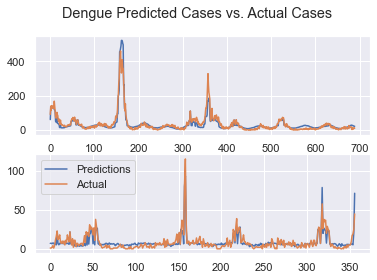

In [37]:

figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
df_x_train_sj['fitted'] = sj_best_model.fittedvalues
df_x_train_sj.fitted.plot(ax=axes[0], label="Predictions")
df_x_train_sj.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
df_x_train_iq['fitted'] = iq_best_model.fittedvalues
df_x_train_iq.fitted.plot(ax=axes[1], label="Predictions")
df_x_train_iq.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()


In [38]:
#Run the model and create the submit file

#For sj
model_sj = smf.glm(formula=formula_sj,
                        data=df_x_train_sj,
                        family=sm.families.NegativeBinomial(alpha=1e-08))

results_sj = model_sj.fit()
predictions_sj = results_sj.predict(df_x_pred_sj).astype(int)


#for IQ
model_iq = smf.glm(formula=formula_iq,
                        data=df_x_train_iq,
                        family=sm.families.NegativeBinomial(alpha=1e-08))

results_iq = model_iq.fit()
predictions_iq = results_iq.predict(df_x_pred_iq).astype(int)


In [39]:
#create the submit file
create_submit_file(predictions_sj,predictions_iq)

#### Recursive Neg Binomial Model
Create a function to re-run the Neg Binomial Mode after each prediction

In [37]:
y_pred_sj=[]

#reset the index of the test and train files
df_x_train_sj.reset_index(inplace=True,drop=True)
df_x_pred_sj.reset_index(inplace=True,drop=True)

#create a scaler for total_cases
tc_scale=MinMaxScaler(feature_range=(0,1))
np_tc=np.array(df_y_train_sj['total_cases'])
np_tc=np.reshape(np_tc,(-1,1))

tc_scale.fit(np_tc)
tc_scale.transform(np_tc)

#Use the unscaled version of the target value to fit the model
df_x_train_sj['total_cases']=df_y_train_sj['total_cases']

#for each record in the holdout file
for i in range(df_x_pred_sj.shape[0]):
    #create, fit and run the model - one record at a time
    model_sj = smf.glm(formula=formula_sj,
                        data=df_x_train_sj,
                        family=sm.families.NegativeBinomial(alpha=0.0001))

    results_sj = model_sj.fit()
    predictions_sj = results_sj.predict(df_x_pred_sj.iloc[i,:]).astype(int)
    y_pred_sj.append(predictions_sj)
    
    if i > 2:
        ##get a scaled version of the total_count
        predictions_sj_sc=np.array(predictions_sj)
        predictions_sj_sc=np.reshape(predictions_sj_sc,(-1,1))
        predictions_sj_sc=tc_scale.transform(predictions_sj_sc)
    
        #Update the row with the current predicted amount. Also update the lag 3 rows following to capture the amount rolling forward
        df_x_pred_sj.loc[i,'total_cases']=int(predictions_sj) #retain unscaled value for iterative fits
        df_x_pred_sj.loc[i+1,'total_cases_shift_1']=predictions_sj_sc #scaled values for supporting data
        df_x_pred_sj.loc[i+2,'total_cases_shift_2']=predictions_sj_sc
        df_x_pred_sj.loc[i+3,'total_cases_shift_3']=predictions_sj_sc
        

In [42]:
y_pred_iq=[]

#reset the index of the test and train files
df_x_train_iq.reset_index(inplace=True,drop=True)
df_x_pred_iq.reset_index(inplace=True,drop=True)

#create a scaler for total_cases
tc_scale=MinMaxScaler(feature_range=(0,1))
np_tc=np.array(df_y_train_iq['total_cases'])
np_tc=np.reshape(np_tc,(-1,1))

tc_scale.fit(np_tc)
tc_scale.transform(np_tc)

#Use the unscaled version of the target value to fit the model
df_x_train_iq['total_cases']=df_y_train_iq['total_cases']

#for each record in the holdout file
for i in range(df_x_pred_iq.shape[0]):
    #create, fit and run the model - one record at a time
    model_iq = smf.glm(formula=formula_iq,
                        data=df_x_train_iq,
                        family=sm.families.NegativeBinomial(alpha=1e-08))

    results_iq = model_iq.fit()
    predictions_iq = results_iq.predict(df_x_pred_iq.iloc[i,:]).astype(int)
    y_pred_iq.append(predictions_iq)
    
    if i > 2:
        ##get a scaled version of the total_count
        predictions_iq_sc=np.array(predictions_iq)
        predictions_iq_sc=np.reshape(predictions_iq_sc,(-1,1))
        predictions_iq_sc=tc_scale.transform(predictions_iq_sc)
    
        #Update the row with the current predicted amount. Also update the lag 3 rows following to capture the amount rolling forward
        df_x_pred_iq.loc[i,'total_cases']=int(predictions_iq)
        df_x_pred_iq.loc[i+1,'total_cases_shift_1']=predictions_iq_sc
        df_x_pred_iq.loc[i+2,'total_cases_shift_2']=predictions_iq_sc
        df_x_pred_iq.loc[i+3,'total_cases_shift_3']=predictions_iq_sc
        

In [43]:
#create the submit file
create_submit_file(y_pred_sj,y_pred_iq)

#### Results
The negative binomial model served as the baseline for the competition. In the baseline test, it achieved a combined MAE score od ~25.5. Using some feature engineering to create features that created moving averages and sums over a variety of weeks and then lagging those values, the negative binomial model achieved an MAE of 22.29. Additionally, the model was run recursively such that after each prediction, the model was updated and run again. This resulted in a reduced score at 24.62.

Finally, an attempt was made to run a classifier which classified each week's data as a 'baseline','outbreak', or 'severe outbreak' week. The classifier was applied to the holdout set and the model run again. With a case severity feature, the model fits extremely well. However, when the the classifier was applied to the hodout set to generate the feature class, and the model run again, results did not improve. It was suspected that this was the case due to an extreme class imbalance. As such SMOTE was applied to the classification to balance the classes. Again, results did not improve.